***Importing the necessary libraries***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

In [ ]:
import seaborn as sns

***Viewing the dataset***

In [ ]:
df = pd.read_csv('/content/truck_fleet.csv')
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


***Exploratory data analysis and preprocessing***

In [ ]:
df2 = df.copy()
df2.date = pd.to_datetime(df2.date)
df2['activedays']=df2.date - df2.date[0]
df2['month'] = df2['date'].dt.month
df2['week_day']=df2.date.dt.weekday
df2['week_day'].replace(0,7,inplace=True)

def str_to_num(str):
  return str.split(' ')[0]

df2.activedays = df2.activedays.astype('str')
df2.activedays = df2.activedays.apply(str_to_num)
df2.activedays = df2.activedays.astype('int')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   metric1     124494 non-null  int64         
 4   metric2     124494 non-null  int64         
 5   metric3     124494 non-null  int64         
 6   metric4     124494 non-null  int64         
 7   metric5     124494 non-null  int64         
 8   metric6     124494 non-null  int64         
 9   metric7     124494 non-null  int64         
 10  metric8     124494 non-null  int64         
 11  metric9     124494 non-null  int64         
 12  activedays  124494 non-null  int64         
 13  month       124494 non-null  int32         
 14  week_day    124494 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(11), object(1

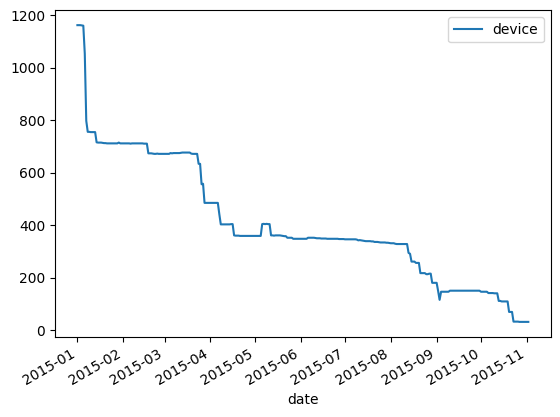

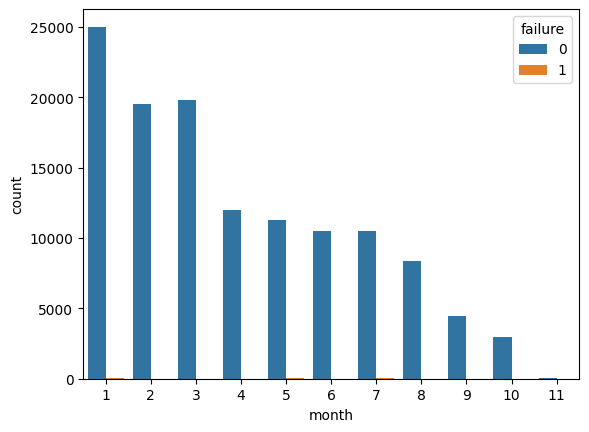

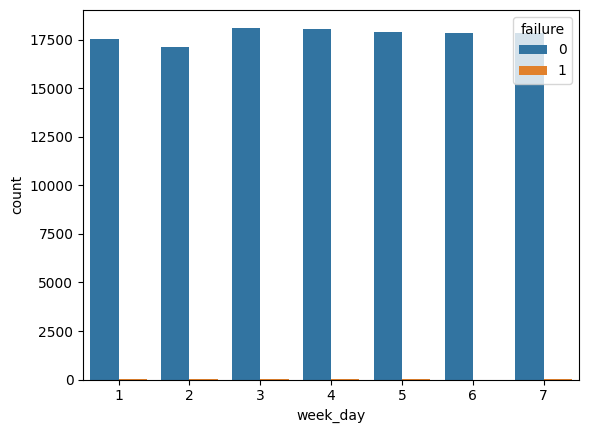

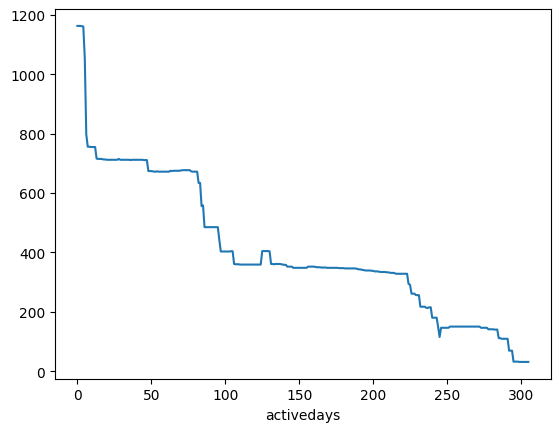

In [ ]:
#group unique device numbers in months
df2.groupby('month').agg({'device': lambda x: x.nunique()})

#visualization in date
df2.groupby('date').agg({'device': lambda x: x.nunique()}).plot()
plt.show()
print()
ax = sns.countplot(x="month", data=df2, hue="failure")
plt.show()
print()
#visualization in week days
ax = sns.countplot(x="week_day", data=df2, hue="failure")
plt.show()
print()
df2.groupby('activedays')['device'].count().plot()
plt.show()


In [ ]:
df2

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,week_day
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,0,1,3
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,0,1,3
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,0,1,3
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,0,1,3
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,305,11,7
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,305,11,7
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,305,11,7
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,305,11,7


***Feature Engineering and Modeling***

1. Determining Remaining Useful Life(RUL)
2. Feature Selection
3. Fitting a Random Forest Classifier

In [ ]:
# Determine RUL
df2_train_RUL = df2.groupby('device').agg({'activedays': 'max'})
df2_train_RUL.rename(columns={'activedays': 'life'}, inplace=True)
df2_train = df2.merge(df2_train_RUL, how='left', on=['device'])
df2_train['RUL'] = df2_train['life'] - df2_train['activedays']
df2_train.drop(['life'], axis=1, inplace=True)

#df2_train['RUL'][df2_train['RUL'] > 125] = 125

# Feature Selection
X = df2_train.drop(['failure','device','metric3','metric4','metric5','metric7','metric9','date'], axis=1)
Y = df2_train.failure

cli = RandomForestClassifier(n_estimators=50, max_features='sqrt')
cli.fit(X, Y)

RandomForestClassifier(n_estimators=50)

In [ ]:
model = SelectFromModel(cli, prefit=True)
#selecting the most relevant features and storing them
X_reduced = model.transform(X)
X_reduced = pd.DataFrame(X_reduced)
X_reduced

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,0,1,2
0,0,0,5
1,0,0,5
2,0,0,47
3,0,0,5
4,0,0,235
...,...,...,...
124489,8,305,0
124490,0,305,0
124491,0,305,0
124492,0,305,0


***Data Scaling and Reshaping for LSTM***

In [ ]:
#splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_reduced, df2_train['RUL'], test_size=0.3, random_state=42)

#scaling the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#reshaping for LSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

LSTM Layers Building

In [ ]:
model = keras.Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(BatchNormalization())
model.add(LSTM(50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(10, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 100)            41600     
                                                                 
 batch_normalization_3 (Bat  (None, 1, 100)            400       
 chNormalization)                                                
                                                                 
 lstm_10 (LSTM)              (None, 1, 50)             30200     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 1, 10)             2440      
                                                                 
 dropout_7 (Dropout)         (None, 1, 10)             0         
                                                      

***Training the model***

In [ ]:
history = model.fit(
    x=X_train_reshaped,
    y=y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=20,
    batch_size=100,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose = 1
)

Epoch 1/20
872/872 [==============================] - 30s 17ms/step - loss: 4827.4512 - val_loss: 409.2065
Epoch 2/20
872/872 [==============================] - 15s 17ms/step - loss: 948.1234 - val_loss: 141.2778
Epoch 3/20
872/872 [==============================] - 16s 19ms/step - loss: 641.6198 - val_loss: 169.7648
Epoch 4/20
872/872 [==============================] - 15s 18ms/step - loss: 494.7239 - val_loss: 61.8002
Epoch 5/20
872/872 [==============================] - 15s 18ms/step - loss: 406.7950 - val_loss: 48.0802
Epoch 6/20
872/872 [==============================] - 15s 17ms/step - loss: 353.2404 - val_loss: 41.0986
Epoch 7/20
872/872 [==============================] - 17s 20ms/step - loss: 320.9849 - val_loss: 68.9797
Epoch 8/20
872/872 [==============================] - 17s 20ms/step - loss: 285.9285 - val_loss: 111.1052
Epoch 9/20
872/872 [==============================] - 13s 15ms/step - loss: 263.4845 - val_loss: 180.9675
Epoch 10/20
872/872 [============================

***Evaluating the Model***

In [ ]:
y_predictions = model.predict(X_test_reshaped)
y_predictions = y_predictions[:, 0][:, 0]
rmse = mean_squared_error(y_test, y_predictions, squared=False)
print(f'Root Mean Squared Error: {rmse}')

1168/1168 [==============================] - 6s 4ms/step
Root Mean Squared Error: 6.410819370747818


***Visualizing the results***

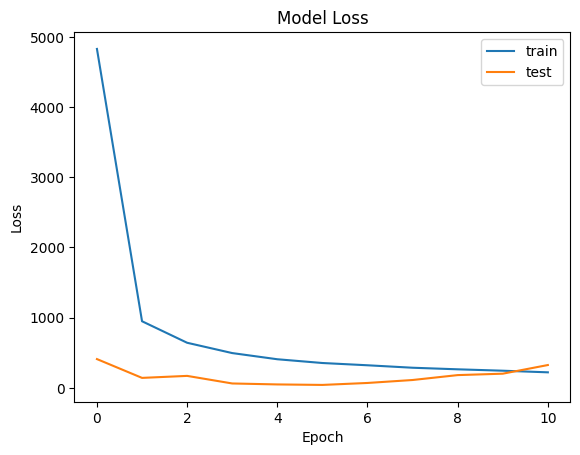

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()